## Basic Concepts in Machine Learning

<center>
<img src="images/overview.png" width="900">
</center>

This lecture will discuss the basic structure and concepts that underly machine learning models, and explore the various types of algorithms used in machine learning through prototype examples. Ultimately the `scikit-learn` python package and other useful programming tools will be introduced. 

* Programming tools
    - scikit-learn
    - scipy
    - autograd
* Machine learning basics:
    - The structure of a machine-learing model
    - Classes of models
    - Model complexity (hyperparameter selection)
    - Model parameter optimization (loss/objective function)
    - Model validation (cross validation)
    - Interpolation vs. Extrapolation
    - Local vs. Global models
* Mathematical background:
    - Linear vs. Non-linear models
    - Linear algebra
    - Numerical optimization
* Prototype algorithms
    - Generalized linear regression
    - kNN (classification)
    - k-means (clustering)
    - PCA (dimensional reduction)


## Programming tools

Machine learning algorithms can be complicated. Luckily, many implementations are openly available in Python through the `scikit-learn` package. There are [tutorials](http://scikit-learn.org/stable/tutorial/index.html) available, and plenty of pages with more [background info](https://machinelearningmastery.com/a-gentle-introduction-to-scikit-learn-a-python-machine-learning-library/).

In [1]:
from sklearn.linear_model import LinearRegression

The [optimization packages](https://docs.scipy.org/doc/scipy/reference/optimize.html) in `scipy` can also be very useful, especially when implementing your own machine learning algorithms.

In [2]:
from scipy.optimize import minimize

Finally, the `autograd` package provides [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation) of python functions. This is a somewhat advanced feature that is generally beyond the scope of this course, but it is a very useful tool to know about.

In [6]:
import autograd.numpy as np   # autograd has its own "version" of numpy that must be used
from autograd import grad # the "grad" function provides derivatives

def position(t):
    s1 = 5
    s2 = 20
    s3 = 40
    if t < 10:
        pos = s1*t
    elif t < 15:
        pos = s2*t - 10*(s2-s1)
    else:
        pos = s3*t - 15*(s3-s2) - 10*(s2-s1)
    return pos

We can take the derivative of this function using `autograd`:

/Users/alex/anaconda3/envs/data/lib/python3.6/site-packages/autograd/core.py:68: UserWarning: Output seems independent of input. Returning zero gradient.
  warnings.warn("Output seems independent of input. Returning zero gradient.")


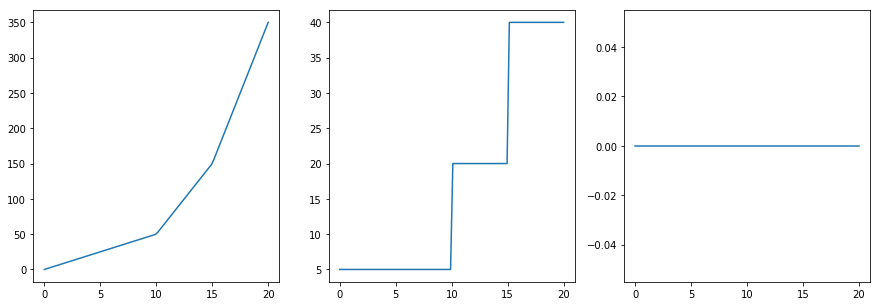

In [7]:
%matplotlib inline
import pylab as plt

t = np.linspace(0,20,100) # create a time series from 0-20 with 100 points
x = [position(ti) for ti in t]
speed = grad(position)
accel = grad(speed)
s = [speed(ti) for ti in t]
a = [accel(ti) for ti in t]

fig, axes = plt.subplots(1,3, figsize=(15,5))
axes[0].plot(t,x)
axes[1].plot(t,s)
axes[2].plot(t,a)

Usually it is most efficient to use a model that is already implemented in `scikit-learn` (or other packages) in a practical scenario, but it is also useful to build your own versions of the algorithms to better understand how they work.

## Machine learning basics

### The structure of a machine-learning model

The goal of machine learning is to utilize only data to "learn" a relationship between an input and an output:

$\vec{y} = f(\vec{x})$

where $f$ is the model, $x$ is the model input and $y$ is the model output. The model inputs, $\vec{x}$ are often called the **features** of a data point. Sometimes the features are easy to obtain directly from the raw data (e.g. numerical attributes like concentration, temperature, pressure, etc.), but as we will see later in the course extracting features from raw data can be a challenge (e.g. images, audio, etc.). Features are "fingerprints" of raw input data.

Of course representing the model as $f$ is a gross oversimplification. The model needs:

* **parameters**, $\vec{W}$, that define its behavior (e.g. slope, intercept)
* **hyperparameters**, $\vec{\eta}$, that define the structure of the model (e.g. the number of polynomial terms)

Notably, $\vec{W}$ will depend on $\vec{\eta}$. So, we can be a little more specific:

$\vec{y} = f(\vec{x}, \vec{W}(\vec{\eta}))$

Machine learning seeks to optimize both $\vec{W}$ (parameter optimization) and $\vec{\eta}$ (complexity optimization) in order to obtain a model that generalizes to new input data.

In [8]:
import pandas as pd
example = pd.read_csv('example.csv')
example.head(10)

,x1,x2,class
0,0.273055,328.795581,0
1,0.797648,197.690321,0
2,0.956190,247.047065,0
3,1.043007,380.460727,0
4,1.430549,338.705346,0
5,1.575510,310.357404,0
6,1.116627,234.046671,0
7,1.421396,402.359107,0
8,1.373570,399.133828,0
9,1.516915,259.488743,0


Text(0,0.5,'y')

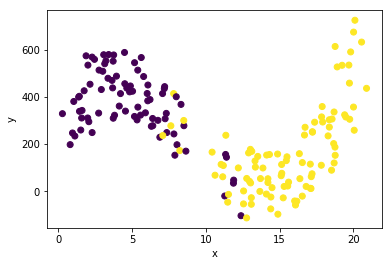

In [13]:
x = example['x1']
y = example['x2']
c = example['class']
fig,ax = plt.subplots()
ax.scatter(x,y,c=c)
ax.set_xlabel('x')
ax.set_ylabel('y')

### Classes of machine-learning models

$\vec{y} = f(\vec{x}, \vec{W}(\vec{\eta}))$

We can classify models based on a few criteria:

#### Supervised vs. Unsupervised

In a "supervised" model we have "training data" for $\vec{y}$, meaning that there are examples to define the pattern/relationship we are looking for.

In an "unsupervised" model $\vec{y}$ is determined by the structure of the inputs $\vec{x}$. This is not really intutive given the way $y=f(x)$ is written; another way of thinking about it is that we look for "inherent" patterns in $\vec{x}$ and those are our "outputs".

#### Supervised models: Classification and regression

Supervised models can be classified by the nature of their outputs. If the output $\vec{y}$ is a continuous variable then it is a **regression** model, while if it is a discrete (boolean, ordinal, integer, etc.) variable then it is a **classification** model.

#### Unsupervised models: Dimensional reduction and clustering

There are two main types of unsupervised learning. **Dimensional reduction** algorithms project high-dimensional (many parameters) inputs ($\vec{x}$) to a lower-dimensional space ($\vec{\tilde{x}}$, where len($\vec{\tilde{x}}$) < len($\vec{x}$)). **Clustering** algorithms assign labels/groups to data points based on similarity metrics. Clustering is like unsupervised classification.

### Example: Polynomial regression  #logistic regresion is used for binary classifiction

$y = b + m*x + p*x^2 + ...$

$y = \beta_0 + \beta_1 x + \beta_2 x^2 + \beta_3 x^3 + \beta_4 x^4 + ...$

$y = \sum_i^N \beta_i x_i^i$ 

In [14]:
from sklearn.linear_model import LinearRegression

def polynomial_features(x, N):
    # function to return a matrix of polynomials for x to order N
    return np.array([x**k for k in range(0,N+1)]).T

X = polynomial_features(x, 4)
print(x.shape,X.shape, y.shape)

(179,) (179, 5) (179,)


The `scikit-learn` approach to polynomial regression is to build up a "feature space" of polynomial transforms of the original data, then use multi-linear regression. The common notation is to refer to the feature space as `X` and output as `y` for supervised models.

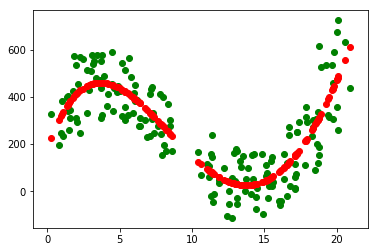

In [18]:
model = LinearRegression(fit_intercept=False)
model.fit(X,y) #<- "fit" the model (optimize the parameters beta_i)
yhat = model.predict(X) #<- get the model predictions (evaluate the optimized function)

fig, ax = plt.subplots()
ax.scatter(x,y, color='g') #<- plot the original data
ax.scatter(x,yhat,color='r')

 ### Model complexity
 
 $\vec{y} = f(\vec{x}, \vec{W}(\vec{\eta}))$
 
 The "complexity" of a model is defined by its hyperparameters ($\vec{\eta}$). The goal of machine learning is to **optimize the complexity** of a model so that it **generalizes to new examples**. In order to achieve this goal we first need a way to quantify complexity so that we can optimize it.
 
 In general there are a few strategies:
 
 * Number of parameters: "Complexity" varies linearly with number of parameters
 * Information criteria: "Complexity" varies logarithmically with number of parameters and is balanced with model accuracy.
 * "Smoothness": "Complexity" is related to the maximum curvature of the model
 
 "With four parameters I can fit an elephant, and with five I can make him wiggle his trunk."
 
 -- John Von Neumann
 
 (see an [example here](https://www.johndcook.com/blog/2011/06/21/how-to-fit-an-elephant/))

### Model parameter optimization

The "parameters" of the model, $\vec{W}$, must also be determined. This is achieved through numerical and/or analytical optimization of a "loss function" or "objective function" ($L(\vec{W})$). This function defines the quality of the model.

Typical loss functions include:

* Sum of squared error (least-squares regression)
* Sum of squared error plus size of parameters (regularization)
* Mean absolute percentage error (neural networks)

#loss function: measures how the model is doing on a single training example


In [19]:
SSE = sum((y-yhat)**2)
MAE = np.sqrt(SSE)/len(y)
MAE

7.4708296985622606

### Model validation

We also need a strategy to see if our model will **generalize to new examples**. This is achieved by "cross-validation", where some examples ("test" examples) are hidden when the model is fit to "training" examples, and the loss function is assessed on the data that was hidden.

There are many strategies for cross-validation:

* hold-out: randomly leave out a percentage (usually ~30%) of the data during training.
* k-fold: select `k` (usually 3-5) randomly-assigned sub-groups of data, and train `k` times holding each group out.
* leave p out: leave `p` (usually 1) samples out of the training and assess the error for the `p` that were left out. Repeat for all possible `p` subsets of the sample.
* bootstrapping: random selection with replacement to generate a sample of the same size as the original dataset, with a number of repetitions.

Cross-validation is used to determine hyperparameters. In this case, even the "test" sets are used to optimize the model. It is common to select an additional "validation" or "holdout" subset for a final validation of the model.

Important (and often violated) assumption: **The collected data is representative of future data.**

MAE (test): 152.281592769


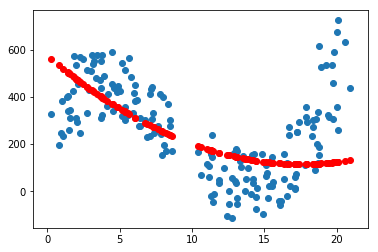

In [21]:
from sklearn.model_selection import train_test_split

N = 2
X = polynomial_features(x, N)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7)

model.fit(X_train,y_train) #<- "fit" the model with training data
yhat = model.predict(X_test) #<- get the model predictions for the test data

SSE = sum((y_test-yhat)**2)
MAE = np.sqrt(SSE/len(y)) #<- evaluate the loss function for the test data
print('MAE (test):', MAE)

fig, ax = plt.subplots()
ax.scatter(x,y) #<- plot the original data
ax.scatter(X_test[:,1],yhat,color='r')

### What is the value of the hyperparameter of the polynomial regression model that optimizes the complexity for this dataset?

### Interpolation vs. Extrapolation

In general, machine learning models can **only** interpolate. There are possible exceptions, but this requires some specialized model development and/or prior knowledge of the nature of the model.

"Extrapolation" with machine learning models is typically achieved through search/exploration algorithms or "adaptive learning". These algorithms utilize machine-learning models to produce an iterative experimental design scheme that involves collection of new data. This effectively turns extrapolation problems into interpolation problems.

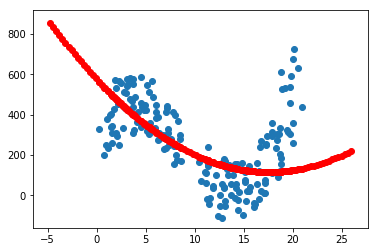

In [22]:
x_extrap = np.linspace(min(x)-5, max(x)+5, 100)
X_extrap = polynomial_features(x_extrap, N)

y_extrap = model.predict(X_extrap) #<- try to make a prediction out of original bounds

ax.scatter(X_extrap[:,1],y_extrap,color='r')
fig

### Parametric vs. Non-parametric

A "parametric" model has parameters that do not explicitly depend on or include the input points. The polynomial regression model is an example of a parametric model. The number of parameters is fixed with respect to the number of data points.

A "non-parametric" model includes some parameters or hyperparameters that are defined on the domain of the independent variable and depend on the inputs. A spline model is an example of a local model. The number of parameters in the model varies with the number of data points.

Nonparametric models are generally excellent for interpolation, but fail miseraly for extrapolation, while parametric models are less accurate for interpolation but provide more reasonable extrapolations. Nonparametric models tend to have many more parameters, and proper optimization of model complexity can lead to similar performance for both types.

See [this post](https://machinelearningmastery.com/parametric-and-nonparametric-machine-learning-algorithms/) for more information.

## Mathematical background

### Linear and non-linear models

<center>
<img src="images/convex.png" width="300">
<img src="images/nonconvex.png" width="300">
</center>

Linear models have a unique solution that can typically be obtained analytically and evaluated using linear algebra. Most linear models can be reduced to:

$ \underline{\underline{A}} \vec{x} = \vec{b} $

or, in summation notation:

$ \sum_i A_{ij} x_{i} = b_j $

Non-linear models have multiple optima, and are considerably more complex. They can be solved with a range of algorithms that are often applied directly to the objective function:

$\frac{\partial L(\vec{W})}{\partial \vec{W}} = 0$

Index notation can be useful for taking derivatives with respect to vectors:

$\frac{\partial L(W_j)}{\partial W_i} = 0$

This is the "Jacobian" ($J_i$) of the loss function. Many optimization algorithms also use the "Hessian" matrix:

$H_{ij} = \frac{\partial^2 L(W_k)}{\partial W_i \partial W_j}$

The "Jacobian" and "Hessian" are multi-dimensional first- and second-derivatives.

### A note on notation

The use of "index" or "summation" notation is common in machine learning, and makes implementation and vector calculus much more convenient. You should be comfortable with (at least) the standard "[vector notation](https://en.wikipedia.org/wiki/Vector_notation)" ($\underline{\underline{A}}$, $\vec{x}$) and "[index notation](https://en.wikipedia.org/wiki/Index_notation)" ($A_{ij}, x_i$). We will often switch between these notations, sometimes even within a single problem/derivation, so you should be comfortable with both.

If you are struggling with index notation [this post](https://math.stackexchange.com/questions/2063241/matrix-multiplication-notation) may help.

## Is polynomial regression a "linear" or "nonlinear" model? Is it "parametric" or "nonparametric"?

## Linear Algebra

You should already be famililar with linear algebra, but we will briefly review the basics and show how it works in `numpy` by covering the following:

Formulating your code as matrix-matrix and matrix-vector operations in Numpy will make it much more efficient. We will briefly cover syntax for:

* scalar*vector
* scalar*matrix
* matrix*vector
* matrix*matrix
* inverse
* solve Ax=b
* eigendecomposition

`numpy` notes:

* reshaping and resizing arrays
* boolean and comparison operators on arrays

### Scalar-array operations

We can use the usual arithmetic operators to multiply, add, subtract, and divide arrays with scalar numbers.

In [23]:
v1 = np.arange(0, 5)
print(v1)
print('-'*10)
print(v1*2)
print('-'*10)
print(v1+2)

[0 1 2 3 4]
----------
[0 2 4 6 8]
----------
[2 3 4 5 6]


Same goes for matrices:

In [24]:
M = np.random.rand(2,2)
print(M)
print('-'*10)
print(M*2)
print('-'*10)
print(M+2)

[[ 0.23974767  0.61929913]
 [ 0.96384322  0.6930855 ]]
----------
[[ 0.47949535  1.23859826]
 [ 1.92768645  1.38617101]]
----------
[[ 2.23974767  2.61929913]
 [ 2.96384322  2.6930855 ]]


### Element-wise array-array operations

When we add, subtract, multiply and divide arrays with each other, the default behaviour is **element-wise** operations. This is different from Matlab!

In [25]:
v1 = np.arange(2,6)
print(v1)
print(v1*v1)
print(v1/v1)

print('-'*10)

M = np.array([[1,2],[3,4]])
print(M)
print(M*M)

[2 3 4 5]
[ 4  9 16 25]
[ 1.  1.  1.  1.]
----------
[[1 2]
 [3 4]]
[[ 1  4]
 [ 9 16]]


### Matrix algebra

What about matrix mutiplication?

* use the `dot` function (recommended)
* use the `matrix` class (`+`, `*`, `-` use matrix algebra)

In [26]:
A = np.eye(3,3)
v = np.array([1,2,3])
print(np.dot(A,v))
print(np.dot(A,A))
print(np.dot(v,v))

A = np.matrix(A)
v = np.matrix(v)
print(A*v.T)
print(A*A)
print(v*v.T)

[ 1.  2.  3.]
[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]
14
[[ 1.]
 [ 2.]
 [ 3.]]
[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]
[[14]]


### Common matrix operations

We can easily calculate the inverse and determinant using `inv` and `det`

In [27]:
A = np.array([[-1,2],[3,-1]])
print(A)
print(np.linalg.inv(A))
print(np.linalg.det(A))

[[-1  2]
 [ 3 -1]]
[[ 0.2  0.4]
 [ 0.6  0.2]]
-5.0


### Linear equation systems

Linear equation systems on the matrix form

$\underline{\underline{A}} \vec{x} = \vec{b}$

where $A$ is a matrix and $x,b$ are vectors can be solved like:

In [28]:
from  scipy.linalg  import solve

N = 3
A = np.random.rand(N,N)
b = np.random.rand(N)

x = solve(A, b)

print(x)
# check
np.dot(A, x) - b
np.isclose(np.dot(A,x),b)

[-0.62768334 -1.18363958  2.51010229]


array([ True,  True,  True], dtype=bool)

We can also do the same with

$\underline{\underline{A}} \underline{\underline{X}} = \underline{\underline{B}}$

where $A, B, X$ are matrices:

In [ ]:
A = np.random.rand(N,N)
B = np.random.rand(N,N)

X = solve(A, B)
# check
np.isclose(np.dot(A, X), B)

### Exercise: Convince yourself that $\underline{\underline{A}} \underline{\underline{X}} = \underline{\underline{B}}$ is equivalent to solving `N` independent systems of the form $\underline{\underline{A}} \vec{x} = \vec{b}$.

### Eigenvalues and eigenvectors

The eigenvalue problem for a matrix $\underline{\underline{A}}$:

$\underline{\underline{A}} v_n = \lambda_n v_n$

where $v_n$ is the $n$th eigenvector and $\lambda_n$ is the $n$th eigenvalue.

To calculate eigenvalues of a matrix, use the `eigvals` function, and for calculating both eigenvalues and eigenvectors, use the function `eig`:

In [29]:
from scipy.linalg import eigvals, eig
evals = eigvals(A)
print(evals)

evals, evecs = eig(A)
print(evals)
print(evecs)

[ 1.36734020+0.j  0.46024761+0.j -0.08622347+0.j]
[ 1.36734020+0.j  0.46024761+0.j -0.08622347+0.j]
[[ 0.65066005  0.99828819 -0.34024225]
 [ 0.46441467 -0.0471611  -0.56358058]
 [ 0.6007999  -0.03459063  0.75273644]]


The eigenvectors corresponding to the $n$th eigenvalue (stored in evals[n]) is the $n$th column in evecs, i.e., evecs[:,n]. To verify this, let's try mutiplying eigenvectors with the matrix and compare to the product of the eigenvector and the eigenvalue:

In [30]:
n = 1

np.dot(A, evecs[:,n]) - evals[n] * evecs[:,n]

array([ -5.55111512e-17+0.j,  -6.59194921e-17+0.j,  -6.59194921e-17+0.j])

Eigendecompositions are very common in machine learning and data analysis, so you should brush up on this if you have forgotten what it means.

## Numpy notes:

### Reshaping and resizing arrays

The shape of an Numpy array can be modified without copying the underlaying data, which makes it a fast operation even for large arrays. There are rules that govern how this reshaping takes place.

In [31]:
import numpy as np
R = np.random.rand(3,3,3)
print(R.shape)
n,m,p = R.shape
Q = R.reshape((n, m*p))
print(Q.shape)
F = R.flatten() #the "flatten" function turns the whole array into a vector
print(F.shape)

(3, 3, 3)
(3, 9)
(27,)


Two common pitfalls in reshaping arrays:

* Reshaping rules do not behave as expected
* Reshaping provides a different "view" of the data, but **does not copy it**

In [32]:
print(R[0,0,0])  #check return copy of array or pointer
print(Q[0,0])
print(F[0])
print(R[0,1,0]) # print(R[0,0,1]) 
print(F[1]) 
print(F[3])

0.481435042108
0.481435042108
0.481435042108
0.211231722146
0.634448168041
0.211231722146


In [33]:
print(R[0,0,0])
Q[0] = 10
print(R[0,0,0]) #resize does not copy the data
F[0] = 6
print(R[0,0,0]) #flatten makes copies

0.481435042108
10.0
10.0


### Making a "deep copy"

If you really want a copy of an array, use the `np.copy` function:

In [ ]:
A = np.array([[1, 2], [3, 4]])
print(A)
B = A
B[0,0] = 10
print(A)
Acopy = np.copy(A)
Acopy[1,1] = 6
print(A)

## Numerical optimization

Optimization (finding minima or maxima of a function) is a large field in mathematics, and optimization of complicated functions or in many variables can be rather involved. Here we will only look at a few very simple cases. For a more detailed introduction to optimization with SciPy see: http://scipy-lectures.github.com/advanced/mathematical_optimization/index.html

We can typically achieve good results using `scipy`'s built-in functions:

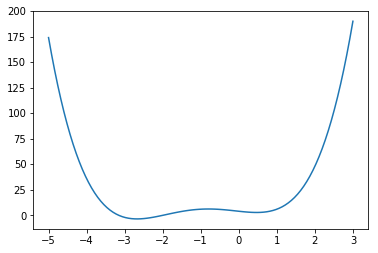

In [34]:
%matplotlib inline
import pylab as plt
 
def f(x):
    return 4*x**3 + (x-2)**2 + x**4

fig, ax  = plt.subplots()
x = np.linspace(-5, 3, 100)
ax.plot(x, f(x))
# answer in x 

There are many types of optimizers available. We will use the common BFGS and CG optimizers here, but you can read more in the [documentation](https://docs.scipy.org/doc/scipy/reference/optimize.html).

In [35]:
from  scipy.optimize  import minimize

x_min = minimize(f, 0.5, method='BFGS') #initial guess is 0.5
x_min

      fun: 2.8049876448687354
 hess_inv: array([[ 0.06288265]])
      jac: array([  3.57627869e-07])
  message: 'Optimization terminated successfully.'
     nfev: 15
      nit: 3
     njev: 5
   status: 0
  success: True
        x: array([ 0.46961745])

A related problem is solving an equation, which can be achieved with the `fsolve` function:

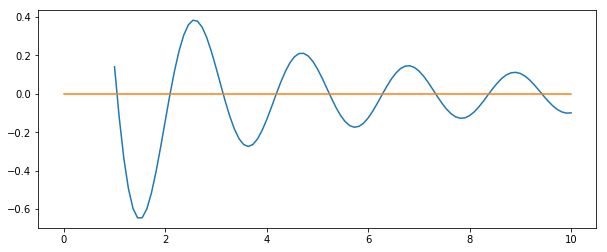

In [37]:
def g(x):
    return np.sin(3*x)*(1/x) #np.sin(3*x)*(1/x)-0.2 to find where f is equal to 0.2 

fig, ax  = plt.subplots(figsize=(10,4))
x = np.linspace(1, 10, 100)
ax.plot(x, g(x))
ax.plot([0,10],[0,0])

In [38]:
from scipy.optimize import fsolve

ans = fsolve(g, 0)
ans

/Users/alex/anaconda3/envs/data/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/alex/anaconda3/envs/data/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
/Users/alex/anaconda3/envs/data/lib/python3.6/site-packages/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


array([ 0.])

# Prototype algorithms

We will introduce a prototype for each class of algorithm with a derivation and/or custom implementation. These algorithms will be revisited later in the course (along with others).

## Generalized linear regression

Generalized linear regression has two basic parts:

1) Generate non-linear transforms of the input data to form new features (optional)

2) Perform multi-linear least-squares regression between the features and the output data.

Polynomial regression is an example of generalized linear regression where the "features" generated in step 1 are polynomials of the original input data.

In [47]:
def polynomial_features(x, N): #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! know the 4 algorithms
    # function to return a matrix of polynomials for x to order N
    return np.array([x**k for k in range(0,N+1)]).T

Now we will write our own multilinear regression function instead of relying on `scikit-learn`.

In [48]:
def multilinear_regression(X,y):  #!!!!!!! know how to derive multlin_regresion
    ## Derive expression
    A = np.dot(X.T,X)
    b = np.dot(X.T,y)
    beta = solve(A,b)
    
    
    return beta
def multilinear_prediciton(X,beta):
    return np.dot(X,beta)

## k Nearest Neighbors (classification)

A simple prototype classification method is the k-nearest neighbors algorithm. This operates on a principle that is very easy to understand: democracy.

The class of a point is determined by letting its k-nearest neighbors "vote" on which class it should be in. The point is assigned to whichever class has the most votes. In the case of a tie, `k` is decreased by 1 until the tie is broken.

The advantage of democracy is that it is "nonlinear" - we can distinguish classes with very complex structures.

We need 3 functions to implement kNN:

* distance metric - calculate the distance between 2 points. We will use the Euclidean distance.
* get neighbors - find the k points nearest to a given point.
* assign class - poll the neighbors to assign the point to a class

In [49]:
def distance(x1, x2):
    # we will use the numpy 2-norm to calculate Euclidean distance:
    return np.linalg.norm(x1-x2, 2) #<- the 2 is optional here since 2 is the default.

In [50]:
def get_neighbor_idxs(x, x_list, k):
    dist_pairs = []
    for i,xi in enumerate(x_list):
        dist = distance(x, xi)
        dist_pairs.append([dist, i, xi]) #<- gives us the distance for each point
    dist_pairs.sort() #<- sort by distance
    k_dists = dist_pairs[:k] #<- take the k closest points
    kNN_idxs = [i for di, i, xi in k_dists] #<- we will get the indices of neighbors instead of the point itself.
    return kNN_idxs

In [51]:
from scipy.stats import mode

def assign_class(x, x_list, y_list, k): #<- now we need to know the responses learn from x_list and y_list
    neighbors = get_neighbor_idxs(x, x_list, k)
    y_list = list(y_list) #<- this ensures that indexing works properly if y_list is a `pandas` object.
    votes = [y_list[i] for i in neighbors]
    assignment = mode(votes)[0][0] #<- we won't deal with ties for this simple implementation
    return assignment

Now we can "wrap" all of these functions into a single function that predicts the class of an array of points:

In [56]:
def kNN(X, k, X_train, y_train):
    y_out = []
    for xi in X:
        y_out.append(assign_class(xi, X_train, y_train, k))
    y_out = np.array(y_out)
    return y_out

Let's see how this works on our example dataset:

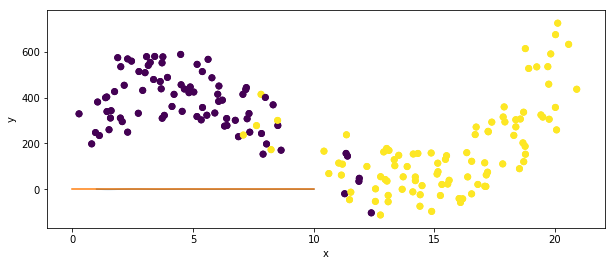

In [53]:
x1 = example['x1'] #<- both of the X columns are now independent variables
x2 = example['x2']
c = example['class'] #<- the "class" column is now the dependent variable
ax.scatter(x1,x2,c=c)
ax.set_xlabel('x')
ax.set_ylabel('y')
fig
#visualize_neigbors = ()  #data normalizing 

In [54]:
X_df = example[['x1','x2']]
X = X_df.values
X.shape

(179, 2)

Text(0.5,1,'kNN prediction')

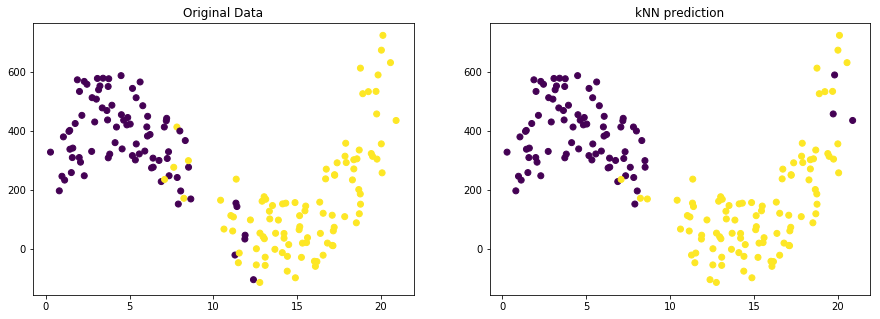

In [57]:
y_model = kNN(X,3,X,c)
fig, axes = plt.subplots(1,2, figsize=(15,5))
axes[0].scatter(x1, x2, c=c)
axes[0].set_title('Original Data')
axes[1].scatter(x1, x2, c=y_model)
axes[1].set_title('kNN prediction')

### Why are the points on the right being mis-classified? How can we fix it?

In [58]:
def visualize_neighbors(X, X_train, k):
    ## helper function to visualize neighbors
    fig, ax = plt.subplots()
    ax.scatter(X[:,0], X[:,1], color='k', alpha=0.2)
    ax.scatter(X_train[:,0], X_train[:,1], color='r', alpha=0.2)
    for xi in X:
        neighbors = get_neighbor_idxs(xi,X_train,k)
        for nj in neighbors:
            xj = X_train[nj]
            ax.plot([xi[0],xj[0]],[xi[1],xj[1]],ls='-',color='b', alpha=0.2)

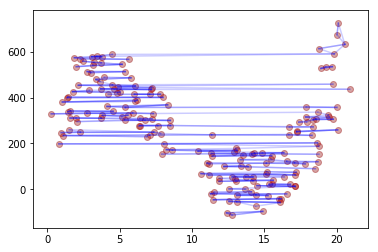

In [59]:
visualize_neighbors(X, X, 3)

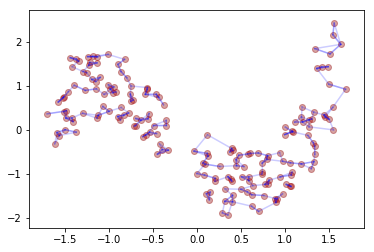

In [60]:
X_scaled = (X - X.mean(axis=0))/X.std(axis=0)
visualize_neighbors(X_scaled, X_scaled, 3)

Text(0.5,1,'kNN prediction')

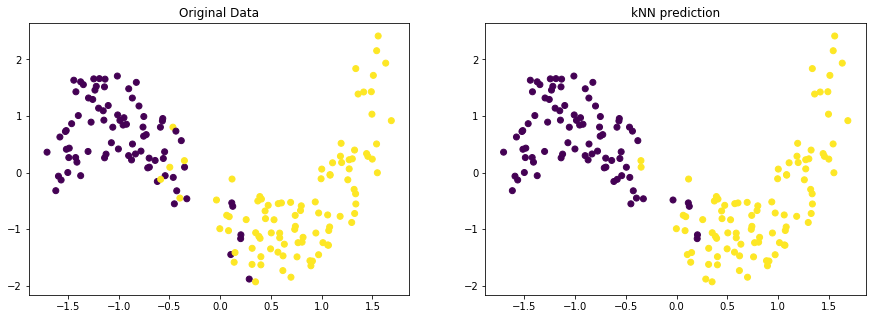

In [61]:
y_model = kNN(X_scaled,3,X_scaled,c) # nearest neigbors allowed to vote is 3 
fig, axes = plt.subplots(1,2, figsize=(15,5))
axes[0].scatter(X_scaled[:,0], X_scaled[:,1], c=c)
axes[0].set_title('Original Data')
axes[1].scatter(X_scaled[:,0], X_scaled[:,1], c=y_model)
axes[1].set_title('kNN prediction')

### Scaling data is like "non-dimensionalizing" or normalizing for different units. This is often critical to ensure that certain variables are not weighted more than others.

Statistical methods don't know about physical units, so we can normalize or "scale" features to aid in comparison:

* rescaling: 0 = min, 1 = max
* mean scaling: 0 = mean, 1 = max, -1 = min
* **standardization: 0 = mean, 1 = standard deviation**
* unit vector: the length of each multi-dimensional vector is 1

See the [scikit-learn documentation](http://scikit-learn.org/stable/modules/preprocessing.html) for more examples and discussion.

## kNN models are non-parameteric, and can easily be "overfit".

In both examples above setting `k=1` will recover the exact correct solution. This is because all the data is included in the training set - the model hasn't "learned" anything, it just memorized the answers. We can avoid this by creating a testing and training set:

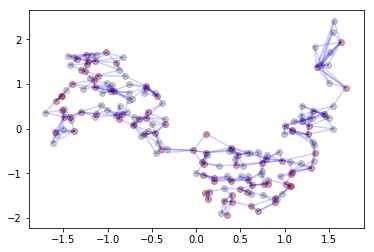

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, c, test_size=0.5) # testsize is hyperparameter 

visualize_neighbors(X_scaled, X_train, 3)

Text(0.5,1,'kNN prediction')

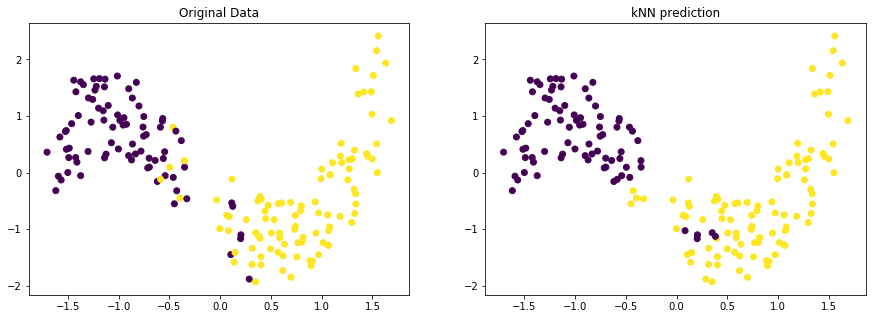

In [63]:
y_model = kNN(X_scaled,3,X_train,y_train)

fig, axes = plt.subplots(1,2, figsize=(15,5))
axes[0].scatter(X_scaled[:,0], X_scaled[:,1], c=c)
axes[0].set_title('Original Data')
axes[1].scatter(X_scaled[:,0], X_scaled[:,1], c=y_model)
axes[1].set_title('kNN prediction')

In this case the number of "parameters" is equal to the number of training data points multiplied by (`X.shape[-1] + y.shape[-1]`). This means that the `test_size` and the method by which the training set is selected (e.g. `random`) are effectively hyperparameters of the model.

### kNN advantages and disadvantages

**Advantages**

* Simple to understand/implement
* Intuitive
* Highly non-linear class boundaries

**Disadvantages**

* Slow for large training sets and/or high dimensions
* Difficult to interpret in high dimensions

## k means (clustering)

The k-means algorithm is the simplest and most intuitive clustering algorithm. It performs remarkably well under a number of assumptions:

* Number of clusters are known
* Clusters are roughly spherical
* Clusters are separated by linear boundaries

Even if these assumptions are violated, it often works anyway, especially in high dimensions (the "blessing" of dimensionality).

The k-means algorithm works using the principal of **expectation-maximization**. This is an iterative type of algorithm that contains two basic steps:

* Expectation: Assign points based on some "expectation" metric.
* Maximization: Revise expectations based on maximizing a fitness metric.

In the case of k-means we:

* Expect that points close to the center of a cluster belong to that cluster
* Maximize the proximity of points to the center of a cluster by moving the center

This process is interated until convergence.

In [64]:
def dist(pt1, pt2):
    "Euclidean distance between two points"
    #note that this can also be performed with np.linalg.norm(pt1-pt2)
    return np.sqrt(sum([(xi-yi)**2 for xi, yi in zip(pt1, pt2)]))

def expected_assignment(pt, cluster_centers):
    dists = [dist(pt,ci) for ci in cluster_centers] #<- find distance to each center
    min_index = dists.index(min(dists)) #<- find the index (cluster) with the minimum dist
    return min_index

def new_centers(cluster_points, centers):
    centers = list(centers)
    for i,ci in enumerate(cluster_points):
        if ci != []:
            centers[i] = np.mean(ci, axis=0)
    return centers

Now we need an "initial guess" of cluster centers and we can run the algorithm:

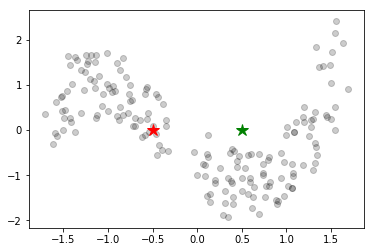

In [65]:
cluster_centers = ([-0.5,0], [0.5,0])
fig, ax = plt.subplots()
ax.scatter(X_scaled[:,0], X_scaled[:,1], color='k', alpha=0.2)
colors = {0:'r', 1:'g'}
for i,ci in enumerate(cluster_centers):
    ax.plot(ci[0], ci[1], marker='*', markersize='12', color=colors[i])

Run the cell below repeatedly to see how the algorithm converges. Re-run the cell above to re-start the algorithm.

[-0.96937793  0.61581738]
[ 0.838108   -0.53242544]


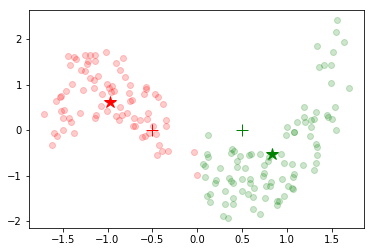

In [66]:
fig, ax = plt.subplots()
# Plot old centers
for i,ci in enumerate(cluster_centers):
    ax.plot(ci[0], ci[1], marker='+', markersize='12', color=colors[i])
    
# Which cluster do we "expect" each point to belong to?
clusters = [[],[],[]]
for pt in X_scaled:
    cluster_idx = expected_assignment(pt, cluster_centers)
    clusters[cluster_idx].append(pt)
    
# What centers best represent these new assignments?
cluster_centers = new_centers(clusters, cluster_centers)

# Plot new assignments
for i, ci in enumerate(clusters):
    for pt in ci:
        ax.plot(pt[0], pt[1], marker='o', color=colors[i], alpha=0.2)
        
# Plot new centers
for i,ci in enumerate(cluster_centers):
    print(ci)
    ax.plot(ci[0], ci[1], marker='*', markersize='12', color=colors[i])
    

If we run the algorithm repeatedly we can see that the centers converge:

In [67]:
for i, ci in enumerate(cluster_centers):
    print('Cluster {} center: {}'.format(i,ci))

Cluster 0 center: [-0.96937793  0.61581738]
Cluster 1 center: [ 0.838108   -0.53242544]


### k-means summary:

**Advantages**

* Fast
* Simple

**Disadvantages**

* Need to know the number of clusters
* Need to have a decent initial guess
* Boundaries are linear and distinct (no probability!)

## Principal component analysis (dimensional reduction)

Principal component analysis, or PCA, is a very common and useful algorithm for dimensional reduction. PCA identifies the linear combinations of input variables that 1) explain the most variance and 2) are orthogonal. It also provides the projection of each data point onto this new principal component space. This is like rotating the coordinate system of the data so that the axes are defined by the variance of the data.

PCA of a dataset yields:

* Principal component vectors
* Principal component values
* Principal component coefficients of data projected onto PC vectors.

PCA is based on the covariance structure of a set of variables. It involves several steps:

 1) Scale the data to remove units (technically optional, but nearly always necessary)

 2) Compute the covariance matrix:

  * Center the data
  
  * Multiply the data by its transpose
     
3) Compute the eigenvalues/eigenvectors of the covariance matric


We can start by looking at our example data. We have already scaled it, and can think of the covariance matrix as the correlation between the different variables:

1.0
-0.400938466891
-0.400938466891
1.0


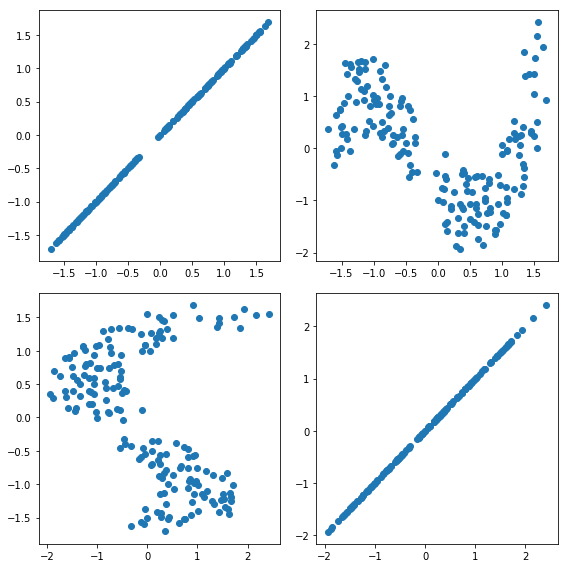

In [68]:
fig, axes = plt.subplots(2,2, figsize = (8,8))

for i in range(X_scaled.shape[1]):
    for j in range(X_scaled.shape[1]):
        xi = X_scaled[:,i]
        xj = X_scaled[:,j]
        axes[i,j].scatter(xi, xj)
        m,b = np.polyfit(xi,xj,1)
        print(m)

fig.tight_layout()

Correlations in features represent redundancy in information. This is called "co-variance", and it is quantified by the covariance matrix:

$\Sigma_{jk} = \frac{1}{n-1}\sum_{i=1}^{N}\left(  x_{ij}-\bar{x}_j \right)  \left( x_{ik}-\bar{x}_k \right)$

Or, in vector notation:

$\Sigma = \frac{1}{n-1} \left( (\mathbf{X} - \mathbf{\bar{x}})^T\;(\mathbf{X} - \mathbf{\bar{x}}) \right)$ 

In [69]:
N = X_scaled.shape[0]
covar = (1/(N-1))*np.dot((X_scaled - X_scaled.mean(axis=0)).T, (X_scaled - X_scaled.mean(axis=0)))
print(covar)

[[ 1.00561798 -0.40319093]
 [-0.40319093  1.00561798]]


This is much more easily accomplished with `numpy`:

In [70]:
covnp = np.cov(X_scaled.T)
print(covnp)

[[ 1.00561798 -0.40319093]
 [-0.40319093  1.00561798]]


We can compare this to the plots above and see that the covariance value is similar to the slope of a linear regression line between the variables.

Note what happens if we use the unscaled version of `X` instead. Variances (and covariances) have units! If your features do not all have the same unit then it is critical to re-scale them.

The principal components are computed by taking the eigenvalues and eigenvectors of the covariance matrix:

In [71]:
PCvals, PCvecs = eig(covar)
print(PCvals)
print(PCvecs)

[ 1.40880891+0.j  0.60242705+0.j]
[[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]


We can super-impose these on the original data

/Users/alex/anaconda3/envs/data/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(-2, 2)

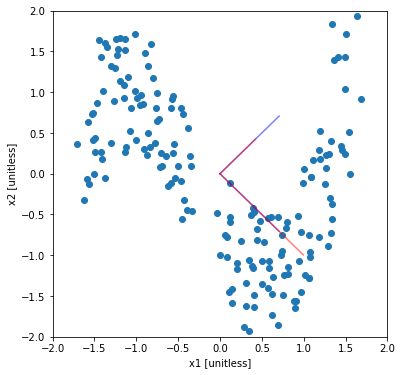

In [72]:
fig,ax = plt.subplots(figsize=(6,6))
ax.scatter(X_scaled[:,0],X_scaled[:,1])
ax.set_xlabel('x1 [unitless]')
ax.set_ylabel('x2 [unitless]')

PCvec1 = PCvecs[:,0] #<- remember that eigenvectors are in the columns!
PCvec2 = PCvecs[:,1]

ax.plot([0, PCvec1[0]],[0,PCvec1[1]], ls='-', color='b', alpha=0.5) #<- plot eigenvectors
ax.plot([0, PCvec2[0]],[0,PCvec2[1]], ls='-', color='b', alpha=0.5)

ax.plot([0, PCvec1[0]*PCvals[0]],[0,PCvec1[1]*PCvals[0]], ls='-', color='r', alpha=0.5) #<- plot eigenvectors scaled by eigenvalues
ax.plot([0, PCvec2[0]*PCvals[1]],[0,PCvec2[1]*PCvals[1]], ls='-', color='r', alpha=0.5)
ax.set_xlim([-2,2])
ax.set_ylim([-2,2])

The PC values are a multi-dimensional generalization of variance. The variance of the data along each principal component is equal to the PC value (standard deviation is equal to the square root of the PC value). This means we can compute the **explained variance** for each principal component axis:

In [73]:
total_variance = np.sum(PCvals)
explained_variance = PCvals/total_variance
print(explained_variance)

[ 0.70046923+0.j  0.29953077+0.j]


This indicates that the first principal component explains ~85% of the variance of the entire data set, and the second principal component explains the additional 15%.

So far we have transformed the dimensions, but we have not reduced them since the data is still 2 dimensional. Reducing the data involves dropping some of the PC vectors and "projecting" the original data onto this subspace. In this case, we will just drop the second one:

(179,)


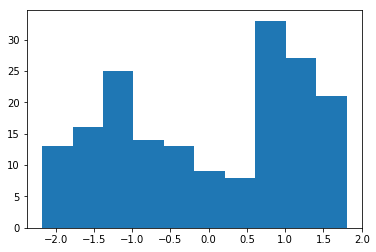

In [74]:
X_1d = np.dot(X_scaled, PCvec1.T)
fig,ax = plt.subplots()
ax.hist(X_1d)
print(X_1d.shape)

We can check this against the `scikit-learn` implementation:

[[-0.70710678  0.70710678]
 [ 0.70710678  0.70710678]]
[ 1.40880891  0.60242705]
[ 0.70046923  0.29953077]
(179, 2)


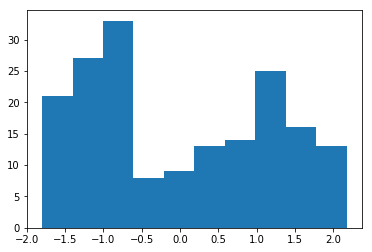

In [75]:
from sklearn.decomposition import PCA

PCA_model = PCA(n_components=2)
PCA_model.fit(X_scaled) #<- the "fit" method finds the PC vectors
print(PCA_model.components_) #<- this is the syntax for PC vectors
print(PCA_model.explained_variance_) #<- this is the syntax for PC values
print(PCA_model.explained_variance_ratio_) #<- this is the syntax for explained variance of each component

X_PCA = PCA_model.transform(X_scaled) #<- the "tranform" method projects the data onto the PC vectors

fig,ax = plt.subplots()
ax.hist(X_PCA[:,0])
print(X_PCA.shape)

Note that the **sign of PC vectors is arbitrary**. This means that PCA projections can vary by a +/- depending on the implementation:

In [76]:
print(np.isclose(X_PCA[:,0], -X_1d).all())

True


### PCA Summary

This example may not seem very useful since the original data is only 2 dimensions, but consider a dataset with 10 features, or 100, or even 10000. PCA identifies which features contain redundant information and provides a route to systematically reduce the number of features in the model. Analyzing the data after projection onto the PC space also allows visualization of the data to look for patterns, etc.

**Advantages**

* Relatively fast

* Easy to visualize/interpret

**Disadvantages**

* Only linear

* Maximum variance may not be a good metric

## Conclusions:

* Machine-learning models map inputs and their **features** to outputs. Their **parameters** control the numerical behavior and the **hyperparameters** control the model structure.

* Model **parameters** are determined by optimizing (minimizing) a loss/objective function. This optimization can be numerical or analytical, and typically relies on linear algebra (linear models) and gradient-based optimization routines (non-linear models).

* Model **hyperparameters** are determined by assessing the tradeoff between model complexity and accuracy to achieve generalizable models. Complexity is controlled by the hyper-parameters, and **cross-validation** is used to assess the generalizability of the model's accuracy.

* Machine learning models can be classified as **supervised** (trained to known dependent variable data) and **unsupervised** (no training data is provided). Supervised models include **regression** (continuous output variable) and **classification** (discrete/ordinal output variable). Unsupervised models include **clustering** (identification of similar groups) and **dimensional reduction** (projection onto fewer independent variables).

* Machine learning models can be **linear** (single unique solution) or **non-linear** (multiple possible solutions), and **parametric** (fixed number of model parameters) or **non-parameteric** (number of parameters varies with amount of input data).

* Prototype models provide insight into the basics of machine learning. You should understand the basics of generalized linear regression, k-nearest neighbor classification, k-means clustering, and principal component analysis.

### Further Reading:

* Watt Machine Learining Refined [Ch1](http://docs.wixstatic.com/ugd/f09e45_ed4e95c1bc8c4f01a3e9858f9a74a5de.pdf) and [Ch2](http://docs.wixstatic.com/ugd/f09e45_2c741285adf14e5aa9fd0696128a1275.pdf) (basics and numerical optimization)
* [Johansson Numpy tutorial](http://github.com/jrjohansson/scientific-python-lectures)
* Hastie Ch. 3 - linear regression
* [Python data science handbook linear regression](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.06-Linear-Regression.ipynb)
* [Sebastian Rauschka regression discussion](https://sebastianraschka.com/faq/docs/closed-form-vs-gd.html)
* Hastie Ch. 13 (pg. 459) - k means and kNN
* [Python kNN implementation](https://machinelearningmastery.com/tutorial-to-implement-k-nearest-neighbors-in-python-from-scratch/)
* [Python Data Science Handbook: k-Means](https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html
* Hastie Ch. 14 (page 534) - PCA
* [PythonMachineLearning notebook](https://github.com/tirthajyoti/PythonMachineLearning/blob/master/Principal%20Component%20Analysis.ipynb)
* [Sebastian Raushka PCA tutorial](http://sebastianraschka.com/Articles/2015_pca_in_3_steps.html)
* [Scikit-Learn PCA documentation](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)